In [1]:
# Imports
import numpy as np
import pandas as pd

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# Customise our plotting settings
rcParams['figure.figsize'] = 10, 5
sns.set_style('whitegrid')

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import StandardScaler

import re
import nltk

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [54]:
# Importing data from csv files using the read_csv() fuction in the pandas library

test= pd.read_csv('data/test_with_no_labels.csv')
train= pd.read_csv('data/train.csv')

In [55]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [56]:
test.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [57]:
sentiment_values = list(train.sentiment.unique())
sentiment_values

[1, 2, 0, -1]

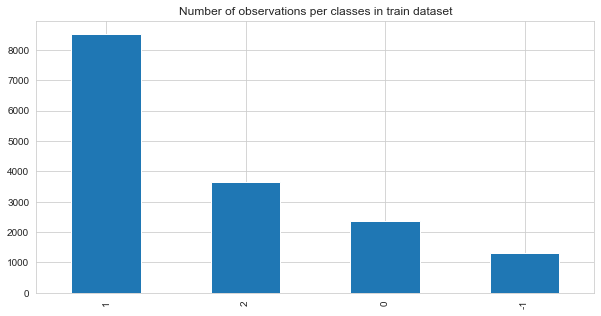

In [58]:
train.sentiment.value_counts().plot(kind='bar')
plt.title('Number of observations per classes in train dataset')
plt.show()

In [59]:
train["sentiment"].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In text analytics, removing noise (i.e. unneccesary information) is a key part of getting the data into a usable format. Some techniques are standard, but your own data will require some creative thinking on your part.

For the MBTI dataset we will be doing the following steps:

removing the web-urls
making everything lower case
removing punctuation
Regular expressions can be very useful for extracting information from text. If you feel brave, go teach yourself all about it... If not, just follow along. This next step effectively removes all websites and replaces them with the text 'web-url'

In [47]:
#pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
#subs_url = r'url-web'
#train['message'] = train['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

In [60]:
def data_cleaning(df):
    stop_words = set(stopwords.words('english'))
    lemm = WordNetLemmatizer()
    Tokenized_Doc=[]
    print("Preprocessing data.........\n")
    for data in df['message']:
        review = re.sub('[^a-zA-Z]', ' ', data)
        url = re.compile(r'https?://\S+|www\.\S+')
        review = url.sub(r'',review)
        html=re.compile(r'<.*?>')
        review = html.sub(r'',review)
        emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        review = emojis.sub(r'',review)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(review)
        gen_tweets = [lemm.lemmatize(token) for token in tokens if not token in stop_words]
        Tokenized_Doc.append(gen_tweets)
        df['tweet tokens'] = pd.Series(Tokenized_Doc)
        
    return df

In [61]:
# Cleaning the data
train_df = data_cleaning(train)
test_df = data_cleaning(test)


Preprocessing data.........

Preprocessing data.........



In [9]:
train.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [57]:
tweets_no_urls_handles = []

for tweet in train['no_handles']:
    tweet_no_urls_sub = re.sub('http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+', '', tweet)
    tweets_no_urls_handles.append(tweet_no_urls_sub)
    
train['no_urls'] = tweets_no_urls_handles
train.head()

,sentiment,message,tweetid,no_handles,no_urls
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...,PolySciMajor EPA chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...,It's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...,698562,RT Researchers say we have three years to act...,RT Researchers say we have three years to act...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...,#TodayinMaker# WIRED : 2016 was a pivotal year...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT It's 2016, and a racist, sexist, climate c...","RT It's 2016, and a racist, sexist, climate c..."


In [58]:
train['no_capitals'] = train['no_urls'].str.lower()
train.head()

,sentiment,message,tweetid,no_handles,no_urls,no_capitals
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...,PolySciMajor EPA chief doesn't think carbon di...,polyscimajor epa chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...,It's not like we lack evidence of anthropogeni...,it's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...,698562,RT Researchers say we have three years to act...,RT Researchers say we have three years to act...,rt researchers say we have three years to act...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...,#TodayinMaker# WIRED : 2016 was a pivotal year...,#todayinmaker# wired : 2016 was a pivotal year...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT It's 2016, and a racist, sexist, climate c...","RT It's 2016, and a racist, sexist, climate c...","rt it's 2016, and a racist, sexist, climate c..."


In [59]:
train['no_capitals'] = train['no_urls'].str.lower()
train.head()

,sentiment,message,tweetid,no_handles,no_urls,no_capitals
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,PolySciMajor EPA chief doesn't think carbon di...,PolySciMajor EPA chief doesn't think carbon di...,polyscimajor epa chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,It's not like we lack evidence of anthropogeni...,It's not like we lack evidence of anthropogeni...,it's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...,698562,RT Researchers say we have three years to act...,RT Researchers say we have three years to act...,rt researchers say we have three years to act...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#TodayinMaker# WIRED : 2016 was a pivotal year...,#TodayinMaker# WIRED : 2016 was a pivotal year...,#todayinmaker# wired : 2016 was a pivotal year...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"RT It's 2016, and a racist, sexist, climate c...","RT It's 2016, and a racist, sexist, climate c...","rt it's 2016, and a racist, sexist, climate c..."


In [64]:
train.drop(['no_handles', 'no_urls'], axis=1, inplace=True)
train.head()

,sentiment,message,tweetid,no_capitals
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesn't think carbon di...
1,1,It's not like we lack evidence of anthropogeni...,126103,it's not like we lack evidence of anthropogeni...
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,#todayinmaker# wired : 2016 was a pivotal year...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"rt it's 2016, and a racist, sexist, climate c..."


In [65]:
from string import punctuation

print(punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [66]:
def remove_punctuation(text_data):
    return ''.join([l for l in text_data if l not in punctuation])

In [67]:
train['no_capitals'] = train['no_capitals'].apply(remove_punctuation)
train.head()

,sentiment,message,tweetid,no_capitals
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired 2016 was a pivotal year in...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its 2016 and a racist sexist climate chang...


In [68]:
from nltk import TreebankWordTokenizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\phahlas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [69]:
tokenizer = TreebankWordTokenizer()

In [70]:
train['tokens'] = train['no_capitals'].apply(tokenizer.tokenize) # turns each column entry into a list of seperate words.
train.head()

,sentiment,message,tweetid,no_capitals,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief doesnt think carbon dio...,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,its not like we lack evidence of anthropogenic...,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,rt researchers say we have three years to act...,"[rt, researchers, say, we, have, three, years,..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired 2016 was a pivotal year in...,"[todayinmaker, wired, 2016, was, a, pivotal, y..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,rt its 2016 and a racist sexist climate chang...,"[rt, its, 2016, and, a, racist, sexist, climat..."


In [71]:
train.drop(['no_capitals'], axis=1, inplace=True)
train.head()

,sentiment,message,tweetid,tokens
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,"[its, not, like, we, lack, evidence, of, anthr..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,"[rt, researchers, say, we, have, three, years,..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"[rt, its, 2016, and, a, racist, sexist, climat..."


In [75]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()


In [76]:
def tweet_lemma(words, lemmatize):
    return [lemmatizer.lemmatize(word) for word in words]

In [77]:
train['lemma'] = train['tokens'].apply(tweet_lemma, args=(lemmatizer, ))
train['lemma']

0        [polyscimajor, epa, chief, doesnt, think, carb...
1        [it, not, like, we, lack, evidence, of, anthro...
2        [rt, researcher, say, we, have, three, year, t...
3        [todayinmaker, wired, 2016, wa, a, pivotal, ye...
4        [rt, it, 2016, and, a, racist, sexist, climate...
                               ...                        
15814    [rt, they, took, down, the, material, on, glob...
15815    [rt, how, climate, change, could, be, breaking...
15816    [notiven, rt, nytimesworld, what, doe, trump, ...
15817    [rt, hey, liberal, the, climate, change, crap,...
15818    [rt, climate, change, equation, in, 4, screens...
Name: lemma, Length: 15819, dtype: object

In [78]:
train.head()

,sentiment,message,tweetid,tokens,lemma
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,"[its, not, like, we, lack, evidence, of, anthr...","[it, not, like, we, lack, evidence, of, anthro..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,"[rt, researchers, say, we, have, three, years,...","[rt, researcher, say, we, have, three, year, t..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,"[todayinmaker, wired, 2016, was, a, pivotal, y...","[todayinmaker, wired, 2016, wa, a, pivotal, ye..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"[rt, its, 2016, and, a, racist, sexist, climat...","[rt, it, 2016, and, a, racist, sexist, climate..."


In [79]:
train.drop(['tokens'], axis=1, inplace=True)
train.head()

,sentiment,message,tweetid,lemma
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,"[it, not, like, we, lack, evidence, of, anthro..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,"[rt, researcher, say, we, have, three, year, t..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,"[todayinmaker, wired, 2016, wa, a, pivotal, ye..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"[rt, it, 2016, and, a, racist, sexist, climate..."


In [80]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phahlas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [81]:
def remove_stop_words(lemmas):
    return [l for l in lemmas if l not in stopwords.words('english')]

In [83]:
train['no_stopwords'] = train['lemma'].apply(remove_stop_words)
train.head()

,sentiment,message,tweetid,lemma,no_stopwords
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,"[polyscimajor, epa, chief, doesnt, think, carb...","[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,"[it, not, like, we, lack, evidence, of, anthro...","[like, lack, evidence, anthropogenic, global, ..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,"[rt, researcher, say, we, have, three, year, t...","[rt, researcher, say, three, year, act, climat..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,"[todayinmaker, wired, 2016, wa, a, pivotal, ye...","[todayinmaker, wired, 2016, wa, pivotal, year,..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"[rt, it, 2016, and, a, racist, sexist, climate...","[rt, 2016, racist, sexist, climate, change, de..."


In [84]:
train.drop(['lemma'], axis=1, inplace=True)
train.head()

,sentiment,message,tweetid,no_stopwords
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,"[polyscimajor, epa, chief, doesnt, think, carb..."
1,1,It's not like we lack evidence of anthropogeni...,126103,"[like, lack, evidence, anthropogenic, global, ..."
2,2,RT @RawStory: Researchers say we have three ye...,698562,"[rt, researcher, say, three, year, act, climat..."
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,"[todayinmaker, wired, 2016, wa, pivotal, year,..."
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,"[rt, 2016, racist, sexist, climate, change, de..."


In [89]:
from sklearn.feature_extraction.text import TfidfVectorizer
vic = TfidfVectorizer()

In [90]:
X_count = vic.fit_transform(train['no_stopwords'].values.astype(str))

ValueError: setting an array element with a sequence

In [12]:
X_count.shape

(15819, 20)

In [14]:
vic.get_feature_names()

['amp',
 'believe',
 'believe climate',
 'change url',
 'doesn',
 'epa',
 'global',
 'global warming',
 'going',
 'just',
 'people',
 'real',
 'trump',
 'url web',
 'url webã',
 'warming',
 'web',
 'web url',
 'webã',
 'world']

In [15]:
X_count.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.59735908, 0.        ,
        0.        ],
       ...,
       [0.        , 0.55091656, 0.60907737, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [16]:
pd.DataFrame(X_count.toarray(),columns=vic.get_feature_names())

,amp,believe,believe climate,change url,doesn,epa,global,global warming,going,just,people,real,trump,url web,url webã,warming,web,web url,webã,world
0,0.0,0.000000,0.000000,0.000000,0.518934,0.561267,0.318736,0.328246,0.0,0.0,0.0,0.0,0.000000,0.222910,0.0,0.327121,0.222826,0.000000,0.0,0.0
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.566696,0.583603,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.581604,0.000000,0.000000,0.0,0.0
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.567188,0.0,0.000000,0.566975,0.597359,0.0,0.0
3,0.0,0.000000,0.000000,0.782716,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.440171,0.0,0.000000,0.440006,0.000000,0.0,0.0
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15814,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.566696,0.583603,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.581604,0.000000,0.000000,0.0,0.0
15815,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.707240,0.0,0.000000,0.706974,0.000000,0.0,0.0
15816,0.0,0.550917,0.609077,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.438714,0.257969,0.0,0.000000,0.257872,0.000000,0.0,0.0
15817,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [17]:
X = X_count.toarray()

In [18]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# Fit label encoder and return encoded labels
y = le.fit_transform(train['sentiment'])

In [19]:
y

array([2, 2, 3, ..., 1, 0, 1], dtype=int64)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [21]:
mnb=MultinomialNB()

In [22]:
mnb.fit(X_train,y_train)

MultinomialNB()

In [23]:
pred=mnb.predict(X_test)

In [24]:
pred

array([1, 3, 2, ..., 2, 2, 1], dtype=int64)

In [25]:
actual=np.array(y_test)
actual

array([0, 3, 3, ..., 0, 2, 2], dtype=int64)

In [26]:
count=0

In [27]:
for i in range(len(pred)):
    if pred[i]==actual[i]:
        count=count+1

In [28]:
count

1837

In [29]:
len(pred)

3164

In [30]:
1837/3164.0

0.5805941845764855

In [31]:
# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

import warnings
warnings.filterwarnings('ignore')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       246
           1       0.33      0.28      0.30       455
           2       0.63      0.82      0.71      1730
           3       0.57      0.41      0.48       733

    accuracy                           0.58      3164
   macro avg       0.38      0.38      0.37      3164
weighted avg       0.52      0.58      0.54      3164



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:

X_count_t = vic.fit_transform(test['message'].values.astype(str))

In [33]:
y_pred_t = mnb.predict(X_count_t)

In [34]:
submission = pd.DataFrame({
    'tweetid': test.tweetid,
    'sentiment': y_pred_t
})

In [35]:
submission.to_csv('submission.csv', index=False)